<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/PreparationDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparation Dataset**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook นี้ใช้สำหรับการจัดเตรียมรูปภาพให้พร้อมก่อนที่จะนำภาพเข้าโมเดล CNN ซึ่งประกอบไปด้วย

1.   การโหลด Dataset จาก Kaggle
2.   การจัดเตรียม Directory สำหรับดึง Image ไปใช้งาน
3.   การแบ่งข้อมูล Training, Validation และ Testing โดยเก็บเป็น Index ในรูปแบบ .csv เพื่อใช้ซ้ำในครั้งถัดไป
4.   การ Visualization images เพื่อรายงานผลเบื้องต้นเกี่ยวกับ Dataset
5.   เสริมการแก้ Imbalanced Dataset ด้วยการ Augmentation

## **Section 0: Import important library**

In [1]:
import pandas as pd
import numpy as np
import random as rd
import tensorflow as tf
import keras
import sklearn

import kagglehub
import os
import shutil
import glob
from tqdm import tqdm
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import missingno as msno
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [3]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [4]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


## **Section 1: Preparing the directory for dataset**

### **In G-Drive Directory**

In [5]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
ASSETS_VISUALIZE_IMG_PATH = f"{ASSETS_PATH}/images" # Visualize Image Assets Path
ORIGINAL_DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000DatasetOriginal"
OVER_DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000DatasetOversampling"
INDEX_PATH = f"{DRIVE_DIR}/datasets/indexSetting"

In [6]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

### **In Runtime Directory**

In [7]:
KAGGLE_BASE_DIR = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", KAGGLE_BASE_DIR)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [8]:
METADATA_PATH = f"{KAGGLE_BASE_DIR}/HAM10000_metadata.csv"
IMAGE_PART_ONE = f"{KAGGLE_BASE_DIR}/HAM10000_images_part_1"
IMAGE_PART_TWO = f"{KAGGLE_BASE_DIR}/HAM10000_images_part_2"

In [9]:
IMAGE_PART_ONE_PATH = glob.glob(os.path.join(IMAGE_PART_ONE, "*.jpg"))
IMAGE_PART_TWO_PATH = glob.glob(os.path.join(IMAGE_PART_TWO, "*.jpg"))
MERGE_IMAGES = IMAGE_PART_ONE_PATH + IMAGE_PART_TWO_PATH
MERGE_DIR = "/content/ham10000Dataset"

In [10]:
paths_dict = {os.path.basename(x).split(".")[0] : x for x in MERGE_IMAGES}
print(f"Number of dictionary elements: {len(paths_dict)}")

Number of dictionary elements: 10015


In [11]:
BASE_DATASET_DIR = "/content/ham10000DatasetOriginal"
OVER_DATASET_DIR = "/content/ham10000DatasetOversampling"

##**Section 2: Data Cleaning**

In [12]:
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [13]:
print("Metadata before cleaning detail")
print("-------------------------------------------")
print(f"Shape of metadata: {metadata.shape}")
print(f"Row of metadata: {metadata.shape[0]}")
print(f"Column of metadata: {metadata.shape[1]}")
print("-------------------------------------------")
print("Check missing value")
print("-------------------------------------------")
print(metadata.isnull().sum())
print("-------------------------------------------")
print("Check data type")
print("-------------------------------------------")
print(metadata.dtypes)
print("Check duplicate value")
print("-------------------------------------------")
print(f"Duplicate value count : {metadata.duplicated().sum()}")

Metadata before cleaning detail
-------------------------------------------
Shape of metadata: (10015, 7)
Row of metadata: 10015
Column of metadata: 7
-------------------------------------------
Check missing value
-------------------------------------------
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64
-------------------------------------------
Check data type
-------------------------------------------
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object
Check duplicate value
-------------------------------------------
Duplicate value count : 0


<Axes: >

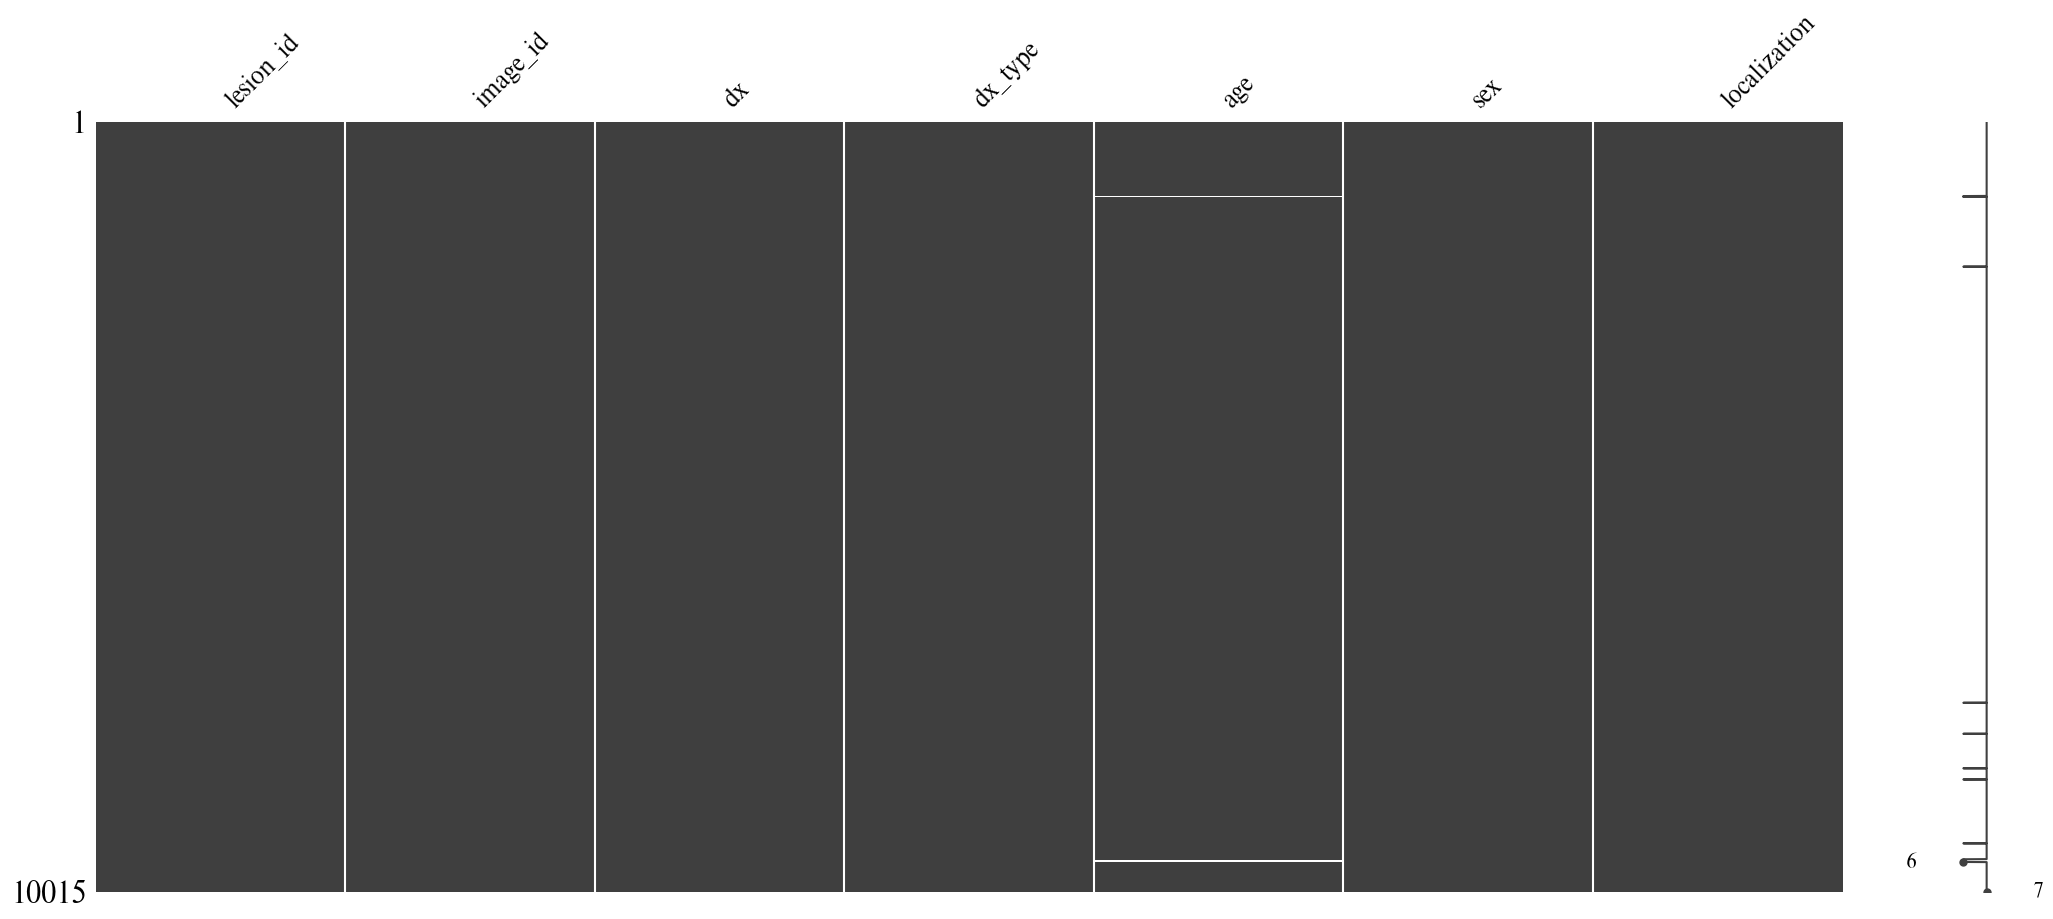

In [14]:
msno.matrix(metadata)

In [15]:
age_mean = metadata["age"].mean()
metadata["age"] = metadata["age"].fillna(age_mean) # แทนที่ค่า NaN ด้วยค่าเฉลี่ย

print("Metadata after cleaning detail")
print("-------------------------------------------")
print(f"Shape of metadata: {metadata.shape}")
print(f"Row of metadata: {metadata.shape[0]}")
print(f"Column of metadata: {metadata.shape[1]}")
print("-------------------------------------------")
print("Check missing value")
print("-------------------------------------------")
print(metadata.isnull().sum())
print("-------------------------------------------")
print("Check data type")
print("-------------------------------------------")
print(metadata.dtypes)
print("Check duplicate valye")
print("-------------------------------------------")
print(f"Duplicate value count : {metadata.duplicated().sum()}")

Metadata after cleaning detail
-------------------------------------------
Shape of metadata: (10015, 7)
Row of metadata: 10015
Column of metadata: 7
-------------------------------------------
Check missing value
-------------------------------------------
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64
-------------------------------------------
Check data type
-------------------------------------------
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object
Check duplicate valye
-------------------------------------------
Duplicate value count : 0


<Axes: >

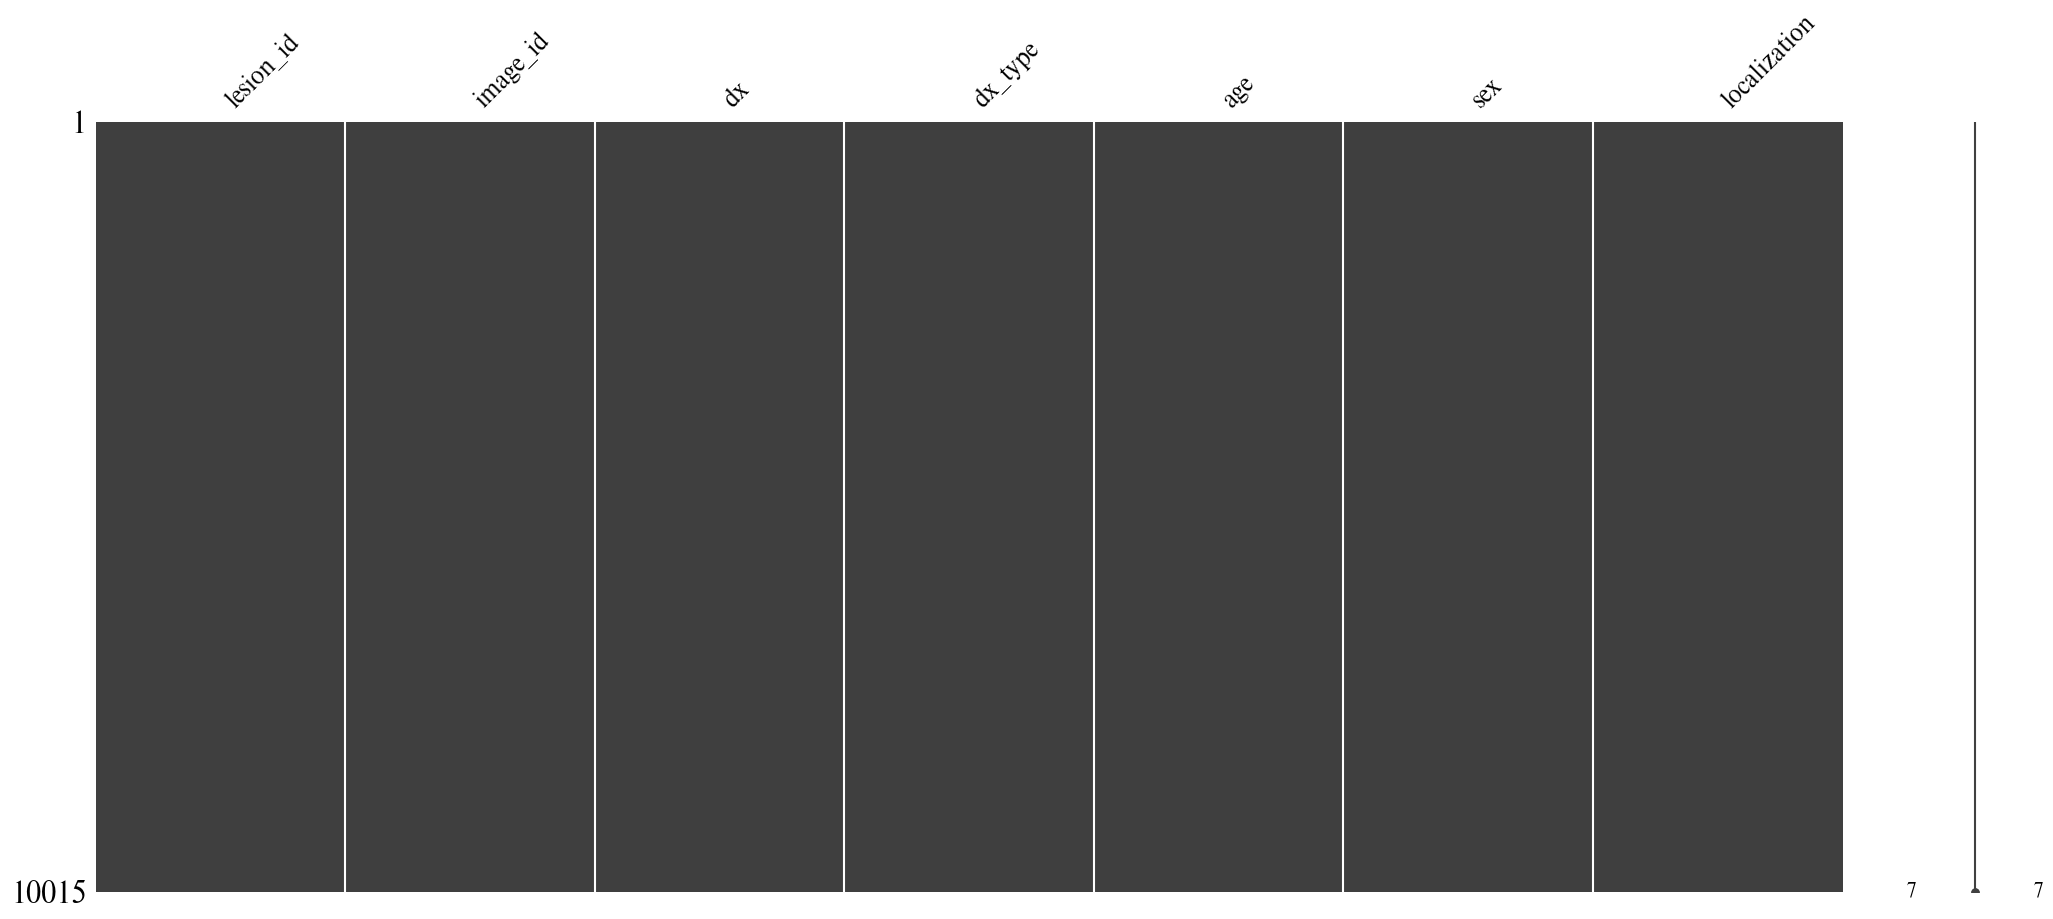

In [16]:
msno.matrix(metadata)

In [17]:
lesion_type_dict = {
    "akiec": "Actinic keratoses",
    "bcc": "Basal cell carcinoma",
    "bkl": "Benign keratosis-like lesions",
    "df": "Dermatofibroma",
    "mel": "Melanoma",
    "nv": "Melanocytic nevi",
    "vasc": "Vascular lesions"
} # เพื่อให้ลำดับ Index เหมือนตอน Train โมเดล

lesion_type_mapping = {v: k for k, v in enumerate(lesion_type_dict.values())}

metadata["filepaths"] = metadata["image_id"].map(paths_dict.get)
metadata["cell_type"] = metadata["dx"].map(lesion_type_dict.get)
metadata["cell_type"] = pd.Categorical(
    metadata["cell_type"],
    categories=[lesion_type_dict[k] for k in lesion_type_dict.keys()],
    ordered=True
)
metadata["cell_type_idx"] = metadata["cell_type"].cat.codes

metadata

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                               filepaths  \
0      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
...                                                  ...   
10010  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10011  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10012  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10013  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10014  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                           cell_type  cell_type_idx  
0      Benign keratosis-like lesions              2  
1      Benign keratosis-like lesions              2  
2      Benign keratosis-like lesions              2  
3      Benign keratosis-like lesions              2  
4      Benign keratosis-like lesions              2  
...                              ...            ...  
10010              Actinic keratoses              0  
10011              Actinic keratoses              0  
10012              Actinic keratoses              0  
10013              Actinic keratoses              0  
10014                       Melanoma              4  

[10015 rows x 10 columns]

In [18]:
print("Recheck class index and cell type")
metadata[["dx", "cell_type", "cell_type_idx"]].drop_duplicates().sort_values("cell_type_idx").reset_index(drop=True)

Recheck class index and cell type


dx                      cell_type  cell_type_idx
0  akiec              Actinic keratoses              0
1    bcc           Basal cell carcinoma              1
2    bkl  Benign keratosis-like lesions              2
3     df                 Dermatofibroma              3
4    mel                       Melanoma              4
5     nv               Melanocytic nevi              5
6   vasc               Vascular lesions              6

In [19]:
metadata.to_csv(f"{INDEX_PATH}/metadata.csv", index=False)

## **Section 3: Verify images and create dataset tree directory**

In [23]:
def verify_images(df, filepaths_col):
    """
        สำหรับตรวจสอบรูปภาพ เพื่อสแกนหาว่ามีภาพที่เสียหรือเปิดไม่ได้หรือไม่
        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
        Return:
            List ที่เก็บชื่อไฟล์ที่พบปัญหา
    """
    corrupted_images = []
    filepaths = df[filepaths_col].values

    for filepath in tqdm(filepaths, desc="Verifying Images"):
        try:
            img = cv2.imread(filepath)
            if img is None:
                corrupted_images.append(filepath)
                os.remove(filepath) # ถ้าเจอภาพเสียลบออก
                print(f"Corrupted or unreadable image removed: {filepath}")
        except Exception as e:
            corrupted_images.append(filepath)
            os.remove(filepath) # ถ้าเจอภาพเสียลบออก
            print(f"Error verifying image: {filepath} - {e}")

    return corrupted_images

In [38]:
corrupted_images = verify_images(metadata, "filepaths")

Verifying Images: 100%|██████████| 10015/10015 [02:47<00:00, 59.65it/s]


In [39]:
print(f"Number of corrupted images: {len(corrupted_images)}")

Number of corrupted images: 0


In [20]:
def merge_directory(df, filepaths_col, labels_col, dest_dir, zip_dir=None):
    """
        สำหรับการ Merge source directorys ตั้งแต่ 2 แหล่งขึ้นไป รวมเป็น 1 เดียว พร้อมกับสร้าง Sub folder ตาม Label ของแต่ละภาพ
        Structure folder:
            Main folder
            |
            |__Label_1
               |_IMG_1.jpg
               |_IMG_2.jpg
               |...
            |__Label_2
               |_IMG_1.jpg
               |_IMG_2.jpg
               |...

        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ และ Column Label สำหรับอ้างอิง Label ของภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label ของภาพ
            dest_dir คือ directory ปลายทาง
            zip_dir (optional) รับค่าเป็น Path ไฟล์เพื่อ zip ไฟล์เก็บไว้
    """
    os.makedirs(dest_dir, exist_ok=True)
    print(f"Destination directory has been created at: {dest_dir}")

    labels = df[labels_col].unique().tolist()
    for label in labels:
        label_dir = os.path.join(dest_dir, label)
        os.makedirs(label_dir, exist_ok=True)

    filepaths = df[filepaths_col].values
    image_labels = df[labels_col].values

    for src_path, image_label in tqdm(zip(filepaths, image_labels), total=len(df), desc="Organizing Images"):
        filename = os.path.basename(src_path)
        dst_path = os.path.join(dest_dir, image_label, filename)
        shutil.copyfile(src_path, dst_path)

    if zip_dir:
        shutil.make_archive(zip_dir, "zip", dest_dir)
        print(f"Zip file has been created at: {zip_dir}")

In [21]:
merge_directory(
    df=metadata,
    filepaths_col="filepaths",
    labels_col="dx",
    dest_dir=MERGE_DIR,
    zip_dir=None
)

Destination directory has been created at: /content/ham10000Dataset


Organizing Images: 100%|██████████| 10015/10015 [01:55<00:00, 86.98it/s]


In [22]:
def directory_to_dataframe(dir):
    """
        สำหรับการทำให้โครงสร้าง Tree directory เก็บเป็น dataframe
         ______________________
        | filepaths |  labels  |
        |___________|__________|
        |  /....... |  Class 1 |
         ----------------------

        Arg:
            dir คือ directory ในลักษณะ Tree
        Return:
            Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ และ Column Label สำหรับอ้างอิง Label ของภาพ
    """
    data = []
    for root, dirs, files in os.walk(dir):
        for filename in files:
            if filename.endswith(".jpg"):
                filepath = os.path.join(root, filename)
                label = os.path.basename(root)
                data.append([filepath, label])

    df = pd.DataFrame(data, columns=["filepaths", "labels"])
    return df

In [23]:
dataset_df = directory_to_dataframe(MERGE_DIR)
dataset_df

filepaths labels
0         /content/ham10000Dataset/nv/ISIC_0033684.jpg     nv
1         /content/ham10000Dataset/nv/ISIC_0024979.jpg     nv
2         /content/ham10000Dataset/nv/ISIC_0032256.jpg     nv
3         /content/ham10000Dataset/nv/ISIC_0027951.jpg     nv
4         /content/ham10000Dataset/nv/ISIC_0029921.jpg     nv
...                                                ...    ...
10010  /content/ham10000Dataset/akiec/ISIC_0024913.jpg  akiec
10011  /content/ham10000Dataset/akiec/ISIC_0028370.jpg  akiec
10012  /content/ham10000Dataset/akiec/ISIC_0030491.jpg  akiec
10013  /content/ham10000Dataset/akiec/ISIC_0027950.jpg  akiec
10014  /content/ham10000Dataset/akiec/ISIC_0024450.jpg  akiec

[10015 rows x 2 columns]

## **Section 4: Visualization images**

In [24]:
def visualize_image_by_class(df, filepaths_col, labels_col, labels_dict, save_path=None, fontsize=20, title="HAM10000 Dataset", num_images=7):
    """
        แสดงรูปภาพ Sample โดยแยกตาม Label ในแต่ละ Row
        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ และ Column Label สำหรับอ้างอิง Label ของภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label ของภาพ
            labels_dict คือ dict ที่เก็บ key เป็นชื่อย่อของ Label และ value เป็นชื่อเต็มของ Label
            save_path (optional) หากใส่ filepath แบบ String จะทำการ Save Image เป็น .png และ .svg
            fontsize คือ ขนาด font (default = 18)
            title คือ ชื่อหัวข้อ
            num_images คือ จำนวนรูปภาพที่ต้องการแสดงในแต่ละแถว
    """
    unique_labels = df[labels_col].unique()
    num_classes = len(unique_labels)

    plt.figure(figsize=(num_images * 3, num_classes * 3))

    for i, label in enumerate(unique_labels):
        label_df = df[df[labels_col] == label]
        sample_paths = label_df[filepaths_col].sample(
            n=min(num_images, len(label_df)),
            random_state=SEED
        ).tolist()

        for j, filepath in enumerate(sample_paths):
            ax = plt.subplot(num_classes, num_images, i * num_images + j + 1)
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis("off")

            if j == 0:
                fullname = labels_dict.get(label, label)
                ax.set_title(f"{fullname} ({label})", loc="left", fontsize=fontsize, pad=10)

    plt.suptitle(title, fontsize=fontsize+2, weight="bold")
    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.05)

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

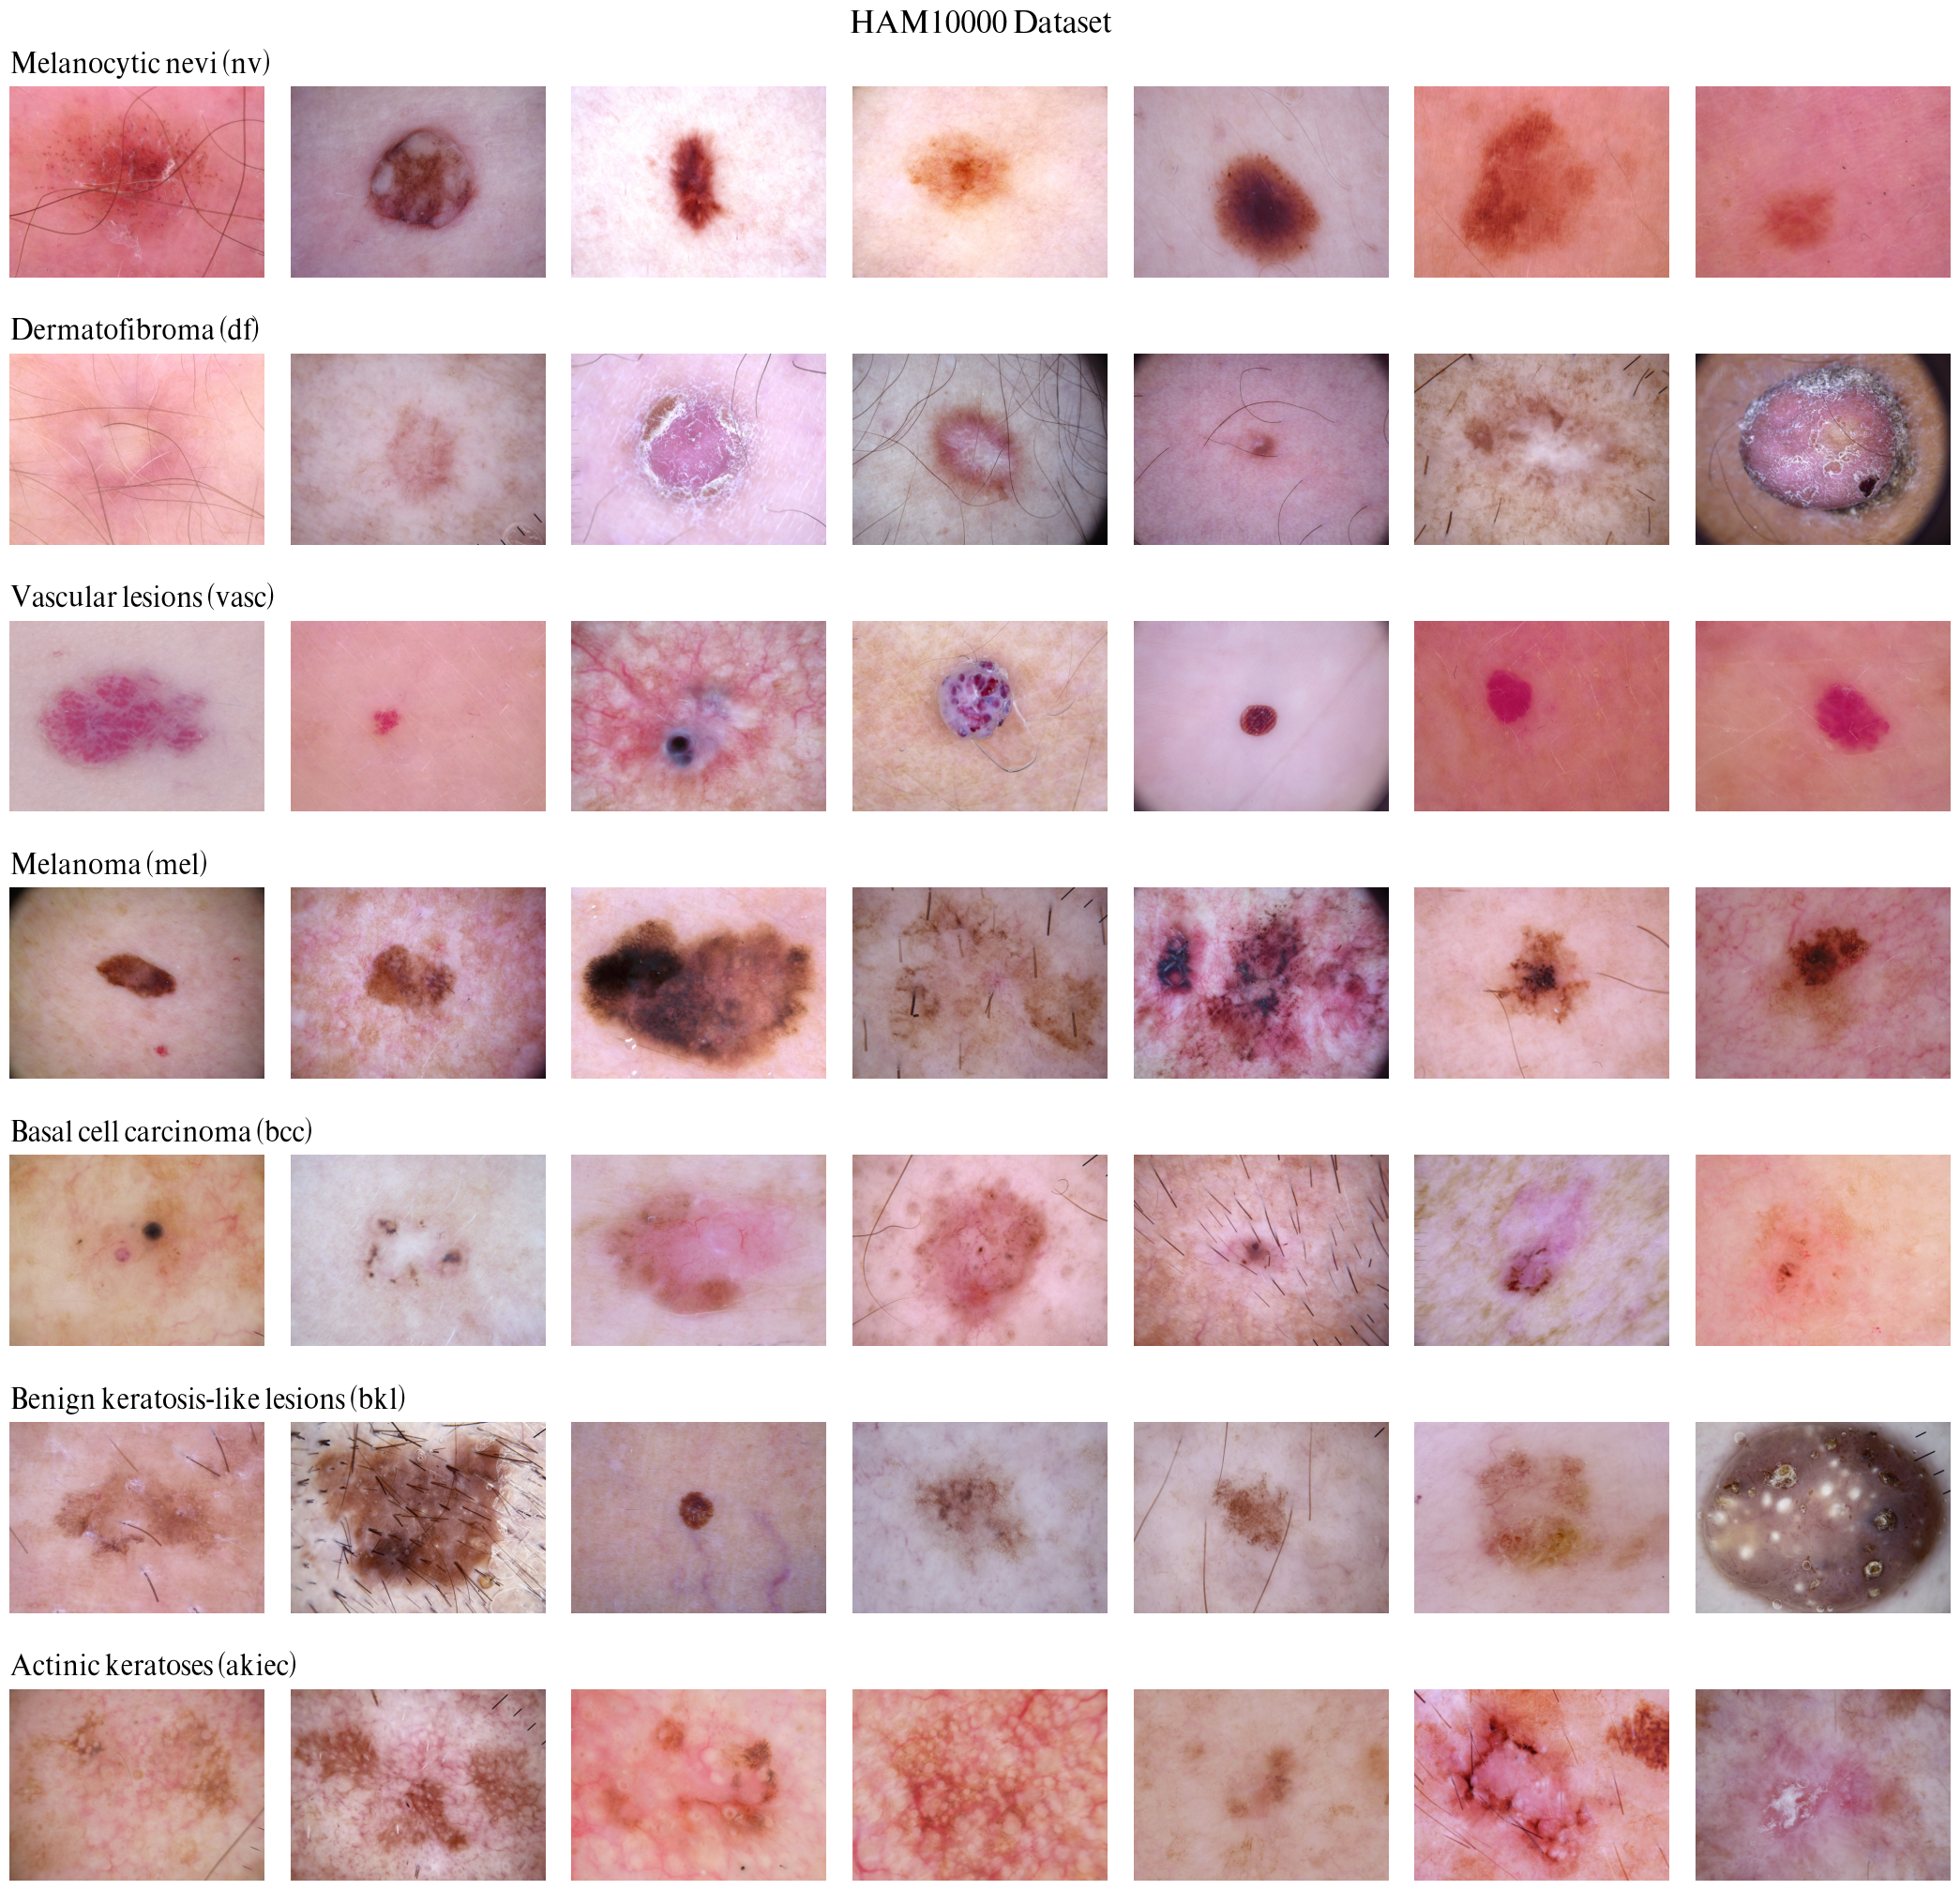

In [29]:
visualize_image_by_class(
    df=dataset_df,
    filepaths_col="filepaths",
    labels_col="labels",
    labels_dict=lesion_type_dict,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/visualize_by_class",
    fontsize=20
)

In [25]:
def plot_distribution(df, labels_col, save_path=None, fontsize=18, title="Class Distribution"):
    """
        แสดงจำนวนรูปภาพในแต่ละ Class แบบ Bar plot
        Args:
            df คือ Pandas dataframe ที่มี Column Label สำหรับอ้างอิง Label ของภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label
            save_path (optional) หากใส่ filepath แบบ String จะทำการ Save Image เป็น .png และ .svg
            fontsize คือ ขนาด font (default = 18)
            title คือ ชื่อหัวข้อ
    """
    class_counts = df[labels_col].value_counts().reset_index()
    class_counts.columns = [labels_col, "count"]

    classes = sorted(df[labels_col].unique())
    palette = sns.color_palette("viridis", n_colors=len(classes))
    class_palette = {cls: palette[i] for i, cls in enumerate(classes)}

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=labels_col,
        y="count",
        data=class_counts,
        hue=labels_col,
        palette=class_palette,
        dodge=False,
        legend=False,
        order=classes
    )

    plt.title(title, fontsize=fontsize+2, weight="bold")
    plt.xlabel("Classes", fontsize=fontsize)
    plt.ylabel("Number of Images", fontsize=fontsize)
    plt.xticks(rotation=45, ha="right", fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    for i, count in enumerate(class_counts.set_index(labels_col).loc[classes]["count"]):
        plt.text(i, count, str(count), ha="center", va="bottom", fontsize=fontsize-2)

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

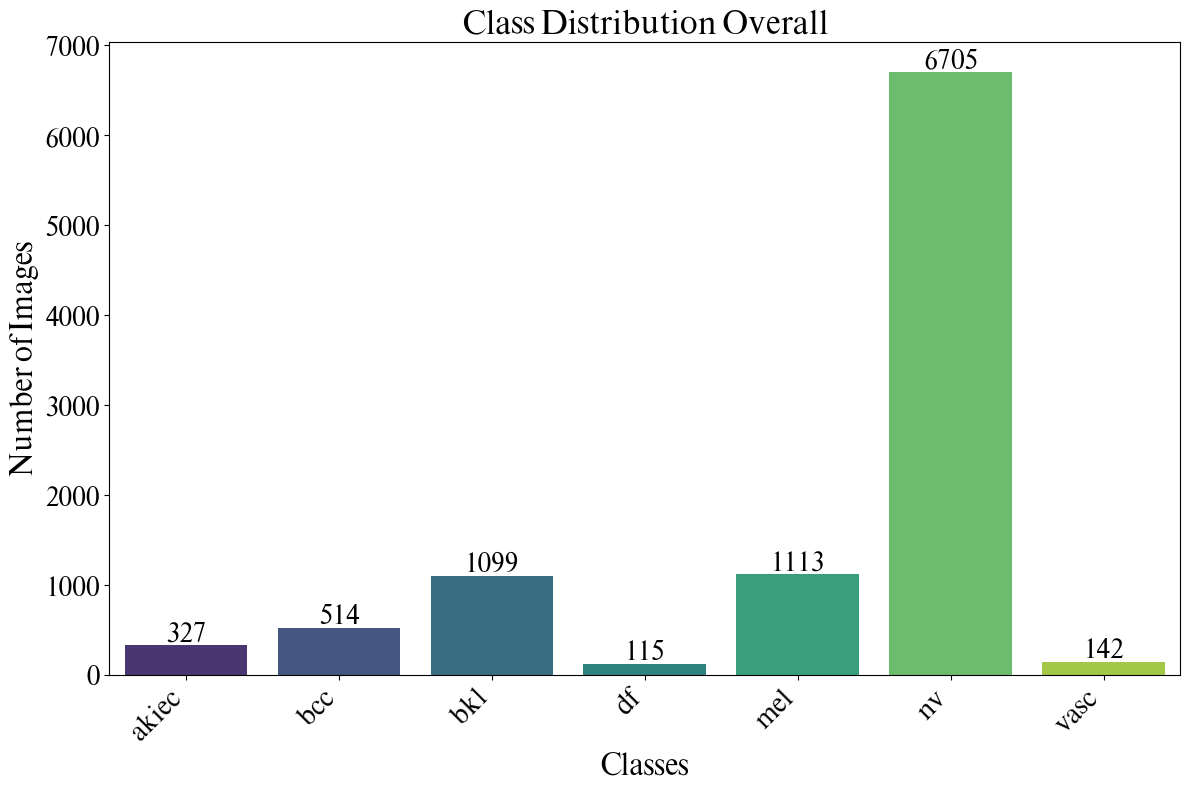

In [68]:
plot_distribution(
    df=dataset_df,
    labels_col="labels",
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/class_distribution",
    fontsize=20,
    title="Class Distribution Overall"
)

## **Section 5: Split data into Train, Validation and Test**

In [26]:
def make_subfolder(train_df, val_df, test_df, filepaths_col, labels_col, dest_dir, zip_dir=None):
    """
    สร้าง Subfolder แยกตาม Train, Validation และ Test
    Structure folder:
        Main folder
        |
        |__train
           |_Label_1
             |_IMG_1.jpg
             |_IMG_2.jpg
             |...
           |_Label_2
             |_IMG_1.jpg
             |_IMG_2.jpg
             |...
    Args:
        train_df คือ Dataframe ของ Train
        val_df คือ Dataframe ของ Validation
        test_df คือ Dataframe ของ Test
        filepaths_col คือชื่อ column ที่เก็บ path ของภาพ
        labels_col คือชื่อ column ที่เก็บ label ของภาพ
        dest_dir คือ directory ปลายทาง
        zip_dir (optional) รับค่าเป็น Path ไฟล์เพื่อ zip ไฟล์เก็บไว้
    """
    splits = {
        "train": train_df.copy(),
        "val": val_df.copy(),
        "test": test_df.copy()
    }

    os.makedirs(dest_dir, exist_ok=True)
    print(f"Destination directory has been created at: {dest_dir}")

    print(f"Making the sub folder")
    for split_name, split_df in splits.items():
        print(f"\nProcessing {split_name} split...")

        for label in split_df[labels_col].unique():
            class_dir = os.path.join(dest_dir, split_name, str(label))
            os.makedirs(class_dir, exist_ok=True)

        new_filepaths = []
        for idx, row in tqdm(split_df.iterrows(), total=len(split_df), desc=f"Copying {split_name}"):
            src_path = row[filepaths_col]
            label = row[labels_col]
            filename = os.path.basename(src_path)
            dst_path = os.path.join(dest_dir, split_name, str(label), filename)

            shutil.copy2(src_path, dst_path)
            new_filepaths.append(dst_path)

        splits[split_name][filepaths_col] = new_filepaths

    if zip_dir:
        shutil.make_archive(zip_dir, "zip", dest_dir)
        print(f"Zip file has been created at: {zip_dir}")

    return splits["train"], splits["val"], splits["test"]

### **Original Dataset 80:10:10**

In [38]:
base_train_df, temp_df = sklearn.model_selection.train_test_split(
    dataset_df,
    test_size=0.2,
    stratify=dataset_df["labels"],
    random_state=SEED
)

base_val_df, base_test_df = sklearn.model_selection.train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["labels"],
    random_state=SEED
)

In [39]:
print(f"Train: {len(base_train_df)}, Validation: {len(base_val_df)}, Test: {len(base_test_df)}")

Train: 8012, Validation: 1001, Test: 1002


In [40]:
base_train_df, base_val_df, base_test_df = make_subfolder(
    train_df=base_train_df,
    val_df=base_val_df,
    test_df=base_test_df,
    filepaths_col="filepaths",
    labels_col="labels",
    dest_dir=BASE_DATASET_DIR,
    zip_dir=ORIGINAL_DATASET_ZIP_PATH
) # Updated Path ด้วย

Destination directory has been created at: /content/ham10000DatasetOriginal
Making the sub folder

Processing train split...


Copying train: 100%|██████████| 8012/8012 [00:24<00:00, 327.55it/s]



Processing val split...


Copying val: 100%|██████████| 1001/1001 [00:02<00:00, 367.18it/s]



Processing test split...


Copying test: 100%|██████████| 1002/1002 [00:03<00:00, 317.31it/s]


Zip file has been created at: /content/drive/MyDrive/CP461/mainProject/datasets/ham10000DatasetOriginal


### **Fixed Imbalanced in Training Set**

In [41]:
def visualize_augmentation(df, transforms_sample, title,
                      n_rows, n_cols, n_samples=1,
                      seed=42, save_path=None, fontsize=16):
    """
    แสดงภาพต้นฉบับและภาพ Augmentation ใน Grid
    Args:
        df: DataFrame ที่มี 'filepaths' และ 'labels'
        transforms_sample: list ของ tuple (name, albumentations transform)
        title: ชื่อ Title หลัก
        n_rows: จำนวนแถว
        n_cols: จำนวนหลัก
        n_samples: จำนวนภาพตัวอย่าง
        seed: random_state สำหรับ sample
        save_path: path สำหรับบันทึกรูป
        fontsize: ขนาดตัวอักษรของ title
    """
    samples = df.sample(n=n_samples, random_state=seed)

    for idx, row in samples.iterrows():
        img_path = row["filepaths"]
        label = row.get("labels", row.get("label", "Unknown"))

        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        n_aug = len(transforms_sample)
        n_cols = n_cols
        n_rows = n_rows

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
        axes = axes.flatten()

        # Original image
        axes[0].imshow(img)
        axes[0].set_title("Original Image", fontsize=fontsize)
        axes[0].axis("off")

        # Augmented images
        for i, (name, aug) in enumerate(transforms_sample):
            aug_img = aug(image=img)["image"]
            axes[i+1].imshow(aug_img)
            axes[i+1].set_title(name, fontsize=fontsize)
            axes[i+1].axis("off")

        for j in range(n_aug+1, len(axes)):
            axes[j].axis("off")

        fig.suptitle(title, fontsize=fontsize+2)
        plt.tight_layout()

        if save_path:
            plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

        plt.show()

In [45]:
def oversampling_images(df, filepaths_col, labels_col, transform, base_dir, zip_dir=None):
    """
    Oversampling ภาพใน base_dir โดยไม่ต้อง copy โฟลเดอร์
    Args:
        df: DataFrame ของ train set
        filepaths_col: column ที่เก็บ path ของภาพ
        labels_col: column ที่เก็บ label
        transform: Albumentations transform
        base_dir: โฟลเดอร์หลักที่เก็บ train/valid/test
        zip_dir (optional): path สำหรับ zip ผลลัพธ์
    Return:
        train_df_aug: DataFrame ของ train set หลัง augment (รวม original + augmented)
    """
    df = df.copy()

    train_dir = os.path.join(base_dir, "train")
    class_counts = df[labels_col].value_counts()
    max_count = class_counts.max()

    new_rows = []

    for label, count in class_counts.items():
        class_df = df[df[labels_col] == label]
        need_count = max_count - count

        if need_count <= 0:
            print(f"Class {label} does not need augmentation.")
            continue

        total_images = len(class_df)
        print(f"\nAugmenting class {label} in train, Original count: {total_images} images.")
        print(f"Need to augment {need_count} new images.\n")

        filepaths = class_df[filepaths_col].tolist()

        for i in tqdm(range(need_count), desc=f"Class {label}"):
            img_path = filepaths[i % total_images]
            img = cv2.imread(img_path)

            if img is None:
                print(f"Error reading image: {img_path} skipped.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = transform(image=img)["image"]

            class_output_dir = os.path.dirname(img_path)  # train/class_name
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            new_filename = f"{base_name}_aug_{i+1}.jpg"
            save_path = os.path.join(class_output_dir, new_filename)

            cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
            new_rows.append({filepaths_col: save_path, labels_col: label})

    augmented_df = pd.DataFrame(new_rows)
    train_df_aug = pd.concat([df, augmented_df], ignore_index=True)

    if zip_dir:
        import shutil
        shutil.make_archive(zip_dir, "zip", base_dir)
        print(f"Zip file has been created at: {zip_dir}")

    return train_df_aug

In [43]:
train_df, temp_df = sklearn.model_selection.train_test_split(
    dataset_df,
    test_size=0.5,
    stratify=dataset_df["labels"],
    random_state=SEED
)

val_df, test_df = sklearn.model_selection.train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["labels"],
    random_state=SEED
)

In [44]:
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 5007, Validation: 2504, Test: 2504


In [46]:
train_df, valid_df, test_df = make_subfolder(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    filepaths_col="filepaths",
    labels_col="labels",
    dest_dir=OVER_DATASET_DIR,
    zip_dir=None
)

Destination directory has been created at: /content/ham10000DatasetOversampling
Making the sub folder

Processing train split...


Copying train: 100%|██████████| 5007/5007 [00:22<00:00, 219.02it/s]



Processing val split...


Copying val: 100%|██████████| 2504/2504 [00:07<00:00, 317.15it/s]



Processing test split...


Copying test: 100%|██████████| 2504/2504 [00:10<00:00, 234.75it/s]


#### **Preview Transformation Process**

In [47]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)},
        rotate=(-30, 30),
        shear=(-20, 20),
        scale=(0.7, 1.3),
        border_mode=cv2.BORDER_REPLICATE,
        p=1.0
    )
], seed=SEED)

In [48]:
# for visualization
geo_transforms = [
    ("Horizontal Flip", A.HorizontalFlip(p=1.0)),
    ("Translation", A.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)}, border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Rotatation", A.Affine(rotate=(-30, 30), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Shear", A.Affine(shear=(-20, 20), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Zoom", A.Affine(scale=(0.7, 1.3), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
]

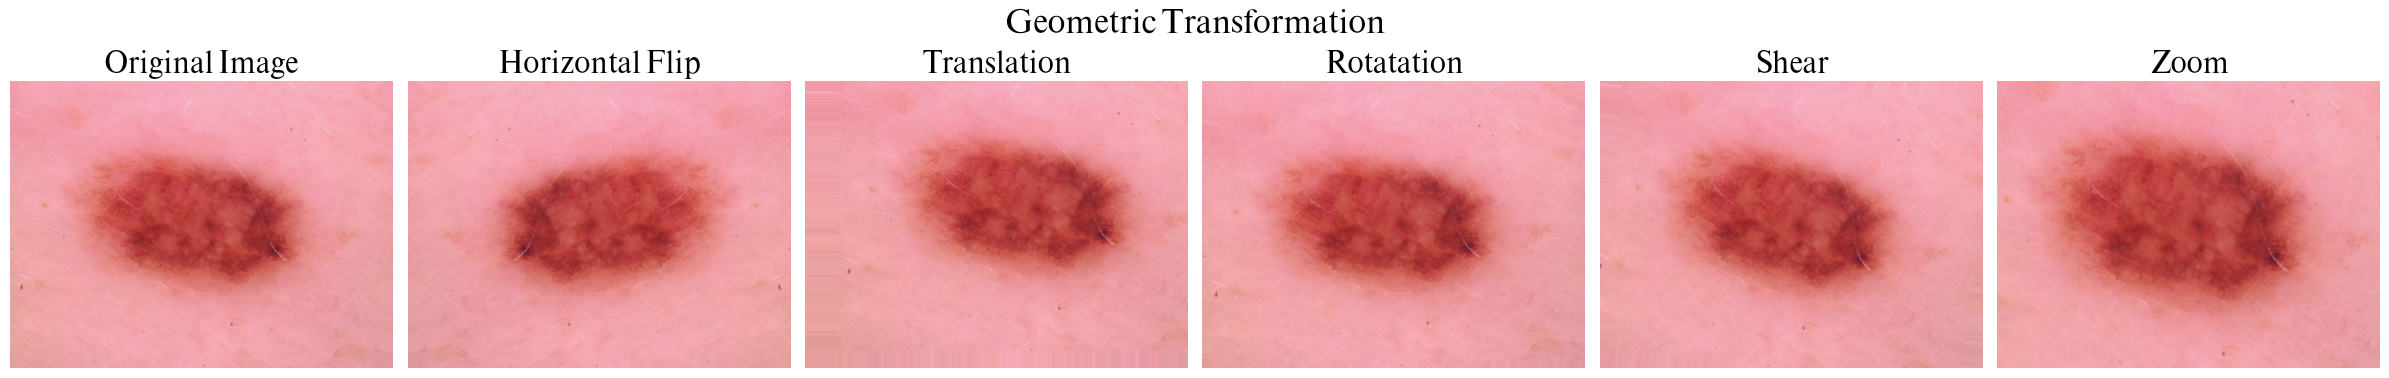

In [108]:
visualize_augmentation(
    df=train_df,
    transforms_sample=geo_transforms,
    title="Geometric Transformation",
    n_rows=1,
    n_cols=6,
    n_samples=1,
    seed=SEED,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/augmentation_sample",
    fontsize=20
)

In [49]:
oversampling_train_df = oversampling_images(
    df=train_df,
    filepaths_col="filepaths",
    labels_col="labels",
    transform=transform,
    base_dir=OVER_DATASET_DIR,
    zip_dir=OVER_DATASET_ZIP_PATH
)

Class nv does not need augmentation.

Augmenting class mel in train, Original count: 556 images.
Need to augment 2796 new images.



Class mel: 100%|██████████| 2796/2796 [00:39<00:00, 70.31it/s]



Augmenting class bkl in train, Original count: 549 images.
Need to augment 2803 new images.



Class bkl: 100%|██████████| 2803/2803 [00:39<00:00, 70.38it/s]



Augmenting class bcc in train, Original count: 257 images.
Need to augment 3095 new images.



Class bcc: 100%|██████████| 3095/3095 [00:43<00:00, 70.41it/s]



Augmenting class akiec in train, Original count: 164 images.
Need to augment 3188 new images.



Class akiec: 100%|██████████| 3188/3188 [00:41<00:00, 77.03it/s]



Augmenting class vasc in train, Original count: 71 images.
Need to augment 3281 new images.



Class vasc: 100%|██████████| 3281/3281 [00:45<00:00, 72.57it/s]



Augmenting class df in train, Original count: 58 images.
Need to augment 3294 new images.



Class df: 100%|██████████| 3294/3294 [00:43<00:00, 75.47it/s]


Zip file has been created at: /content/drive/MyDrive/CP461/mainProject/datasets/ham10000DatasetOversampling


## **Section 6: Summary Process**

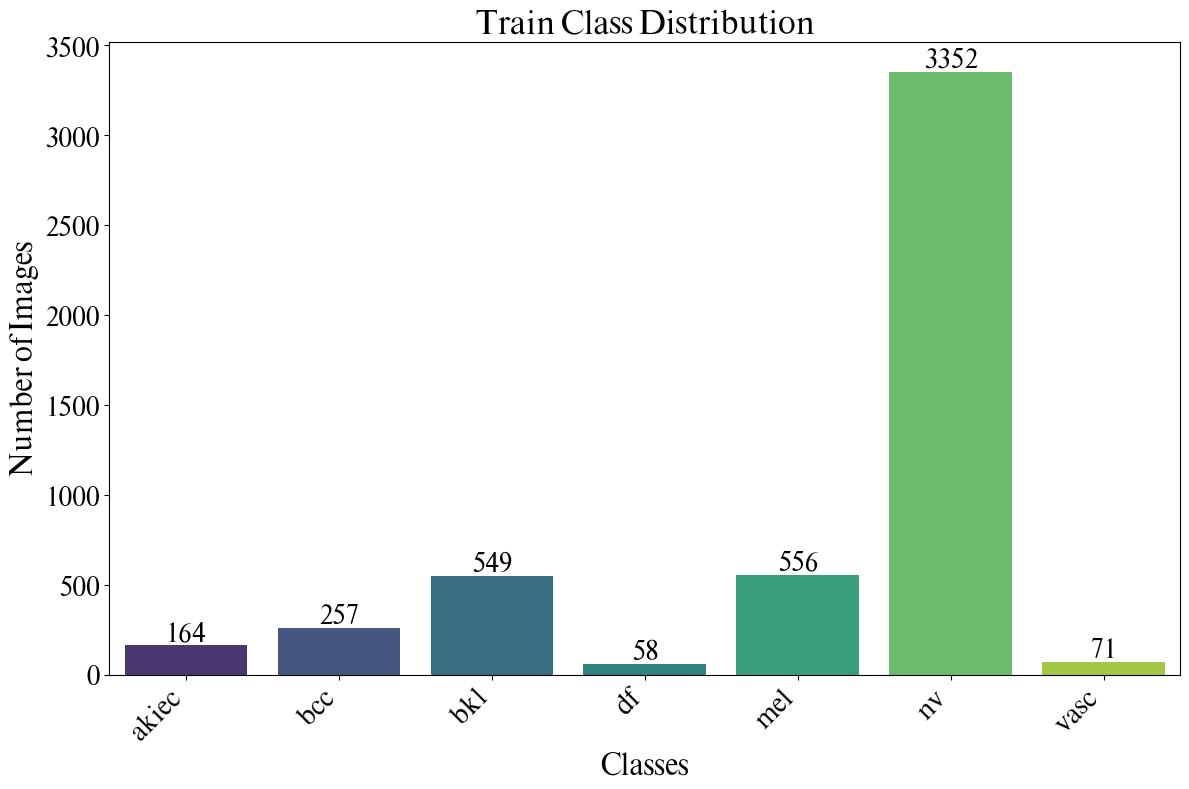

In [51]:
plot_distribution(
    df=train_df,
    labels_col="labels",
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/train_class_distribution_original",
    fontsize=20,
    title="Train Class Distribution"
)

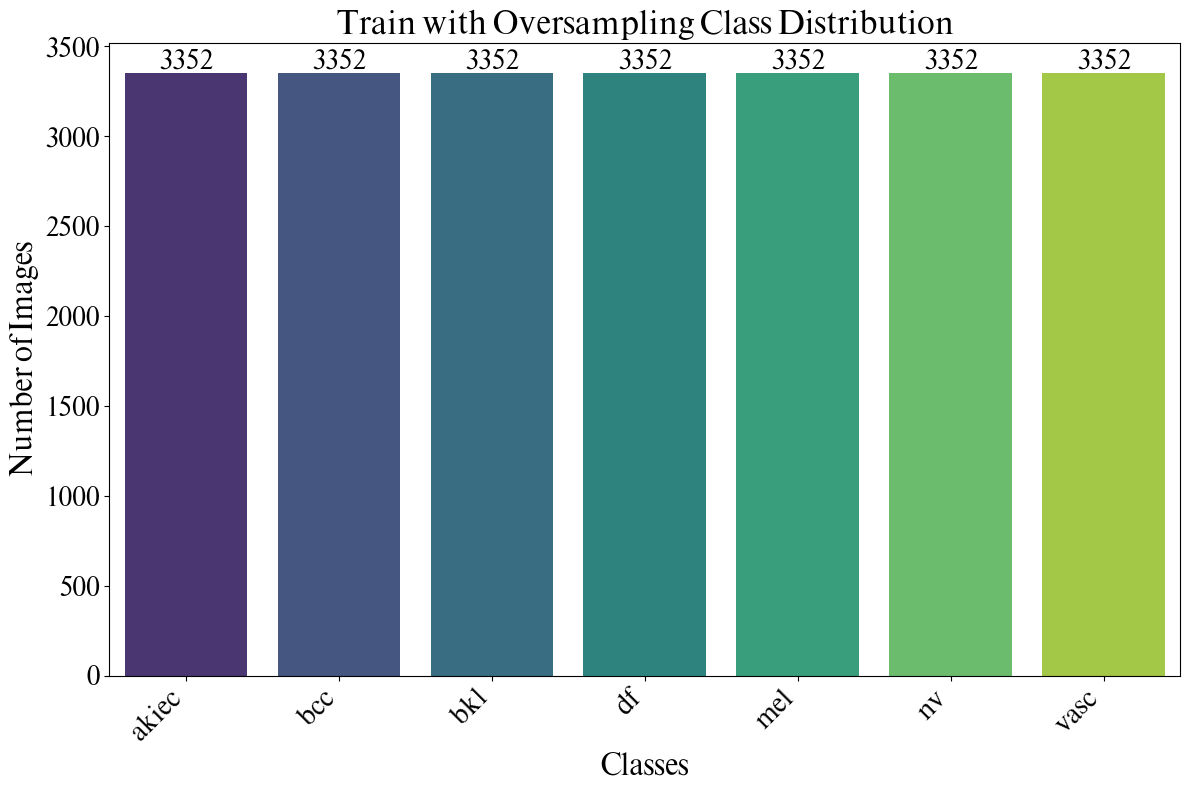

In [52]:
plot_distribution(
    df=oversampling_train_df,
    labels_col="labels",
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/train_class_distribution_original",
    fontsize=20,
    title="Train with Oversampling Class Distribution"
)

In [76]:
labels = dataset_df["labels"].unique().tolist()

total_count = []
train_count = []
valid_count = []
test_count = []

for label in labels:
    total_count.append(dataset_df[dataset_df["labels"] == label].shape[0])
    train_count.append(base_train_df[base_train_df["labels"] == label].shape[0])
    valid_count.append(base_val_df[base_val_df["labels"] == label].shape[0])
    test_count.append(base_test_df[base_test_df["labels"] == label].shape[0])

summary_df = pd.DataFrame({
    "Class": labels,
    "Total (100%)": total_count,
    "Training (80%)": train_count,
    "Validation (10%)": valid_count,
    "Testing (10%)": test_count
})
summary_df.to_csv(f"{INDEX_PATH}/dataset_desc.csv", index=False)

print("Dataset overall description without oversampling")
print("=====================================================================")
print(summary_df.to_string(index=False))
print("=====================================================================")
print(f"Training total count: {sum(train_count)}")
print(f"Validation total count: {sum(valid_count)}")
print(f"Testing total count: {sum(test_count)}")

Dataset overall description without oversampling
Class  Total (100%)  Training (80%)  Validation (10%)  Testing (10%)
   nv          6705            5364               670            671
   df           115              92                12             11
 vasc           142             114                14             14
  mel          1113             890               111            112
  bcc           514             411                51             52
  bkl          1099             879               110            110
akiec           327             262                33             32
Training total count: 8012
Validation total count: 1001
Testing total count: 1002


In [77]:
labels = dataset_df["labels"].unique().tolist()

total_count = []
train_count = []
train_with_oversampling_count = []
valid_count = []
test_count = []

for label in labels:
    total_count.append(dataset_df[dataset_df["labels"] == label].shape[0])
    train_count.append(train_df[train_df["labels"] == label].shape[0])
    train_with_oversampling_count.append(oversampling_train_df[oversampling_train_df["labels"] == label].shape[0])
    valid_count.append(valid_df[valid_df["labels"] == label].shape[0])
    test_count.append(test_df[test_df["labels"] == label].shape[0])

summary_oversampling_df = pd.DataFrame({
    "Class": labels,
    "Total (100%)": total_count,
    "Training (50%)": train_count,
    "Training with Oversampling": train_with_oversampling_count,
    "Validation (25%)": valid_count,
    "Testing (25%)": test_count
})
summary_oversampling_df.to_csv(f"{INDEX_PATH}/dataset_desc_oversampling.csv", index=False)

print("Dataset overall description with oversampling")
print("=======================================================================================================")
print(summary_oversampling_df.to_string(index=False))
print("=======================================================================================================")
print(f"Training with oversampling total count: {sum(train_with_oversampling_count)}")
print(f"Validation total count: {sum(valid_count)}")
print(f"Testing total count: {sum(test_count)}")

Dataset overall description with oversampling
Class  Total (100%)  Training (50%)  Training with Oversampling  Validation (25%)  Testing (25%)
   nv          6705            3352                        3352              1676           1677
   df           115              58                        3352                28             29
 vasc           142              71                        3352                36             35
  mel          1113             556                        3352               278            279
  bcc           514             257                        3352               129            128
  bkl          1099             549                        3352               275            275
akiec           327             164                        3352                82             81
Training with oversampling total count: 23464
Validation total count: 2504
Testing total count: 2504
